# Hub'Eau time series univariate forecasting

Setup our working environment first in order to be able to display some data and make training/prediction:

In [101]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

Then read data from a station and display it:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002C450CA9D08>],
      dtype=object)

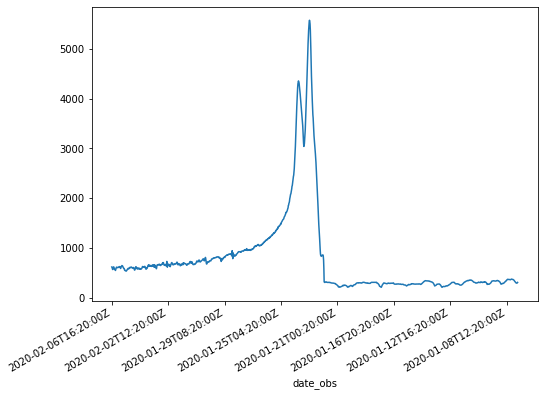

In [102]:
raw = pd.read_csv("data/hubeau_site_Y1422030_30d_30m_L'Aude.csv", delimiter=';')
data = raw['resultat_obs']
data.index = raw['date_obs']
data.head()
data.plot(subplots=True)

We will work with two setups:
* a single step setup where the model learns to predict a single point in the future based on some history provided
* a multi-step setup where given a past history the model needs to learn to predict a range of future values 

Let's say you want to predict the water level 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 240 (5x48) observations to train the model if your time step is 30 minutes (2 observations per hour). Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict, ie the label(s) that needs to be predicted.


In [103]:
def data_windows(dataset, start_index, end_index, history_size, target_size, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    if single_step:
      labels.append(dataset[i+target_size])
    else:
      labels.append(dataset[i:i+target_size])
    
  return np.array(data), np.array(labels)

Now we define some constants for model fit and some helper functions to display model performances:

In [104]:
epochs = 10
steps_per_epoch = 1000
validation_steps = 500
        
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))

  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

def show_single_plot(plot_data, future, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = list(range(-plot_data[0].shape[0], 0))
  if future:
    delta = future
  else:
    delta = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(delta, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (delta+5)])
  plt.xlabel('Time Step')
  plt.show()

def show_multiple_plot(history, true_future, prediction, title):
  plt.figure(figsize=(12, 6))
  num_in = list(range(-len(history), 0))
  num_out = len(true_future)

  plt.title(title)
  plt.plot(num_in, np.array(history), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
    
def show_prediction(data, prediction, title):
  if data:
    time_steps = list(range(0, len(data)))
  else:
    time_steps = list(range(0, len(prediction)))
  plt.title(title)
  if data:
    plt.plot(time_steps, np.array(data), '-', label='Data')
  if prediction:
    plt.plot(time_steps, np.array(prediction), '-', label='Model Prediction')
  plt.legend()
  plt.xlabel('Time Step')
  plt.show()

Let's keep 75% of data to train (remaining will be the validation dataset) and standardize the data:

In [105]:
train_split = round(data.size * 0.75)
print('Training dataset length is {} for total data length {}'.format(train_split, data.size))
mean = data.values[:train_split].mean()
std = data.values[:train_split].std()
print ('Training Mean value {} - Std value {}'.format(mean, std))
ndata = (data.values-mean)/std

Training dataset length is 1080 for total data length 1440
Training Mean value 920.0824074074075 - Std value 952.5603284412648


We first start with the single step setup: the model learns to predict a single point in the future based on some history provided. Let's now create the data for the model, it will be given the last N recorded observations (eg 24 observations - 12H if your time step is 30 minutes), and needs to learn to predict the level in Y hours (eg 8 observations - 4H ahead if your time step is 30 minutes).

Timestep 30m - History 12h - Looking 240m ahead
Sample window [[-0.32027621]
 [-0.33182403]
 [-0.35491968]
 [-0.37381612]
 [-0.37171652]
 [-0.34967067]
 [-0.3192264 ]
 [-0.3192264 ]
 [-0.34232205]
 [-0.35177027]
 [-0.37066671]
 [-0.37696553]
 [-0.38116474]
 [-0.39376236]
 [-0.37696553]
 [-0.35491968]
 [-0.33287383]
 [-0.32342561]
 [-0.32762482]
 [-0.32867462]
 [-0.33182403]
 [-0.33707304]
 [-0.33182403]
 [-0.32657502]]
Target level value -0.34232205317745795


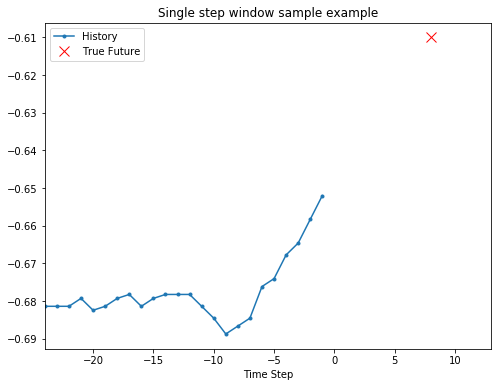

In [106]:
timestep = 30 # in minutes, can be 10, 30 or 60
perHour = round(60 / timestep) # number of observation per hour
history = (12 * perHour) # N hours history
future = (4 * perHour) # Predict N hours ahead

print ('Timestep {}m - History {}h - Looking {}m ahead'.format(timestep, round(history / perHour), future*timestep))

x_train, y_train = data_windows(ndata, 0, train_split, history, future, single_step=True)
x_validate, y_validate = data_windows(ndata, train_split, None, history, future, single_step=True)

print ('Sample window {}'.format(x_train[0]))
print ('Target level value {}'.format(y_train[0]))

show_single_plot([x_validate[0], y_validate[0]], future, 'Single step window sample example')

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. In this experiment, we will use a specialized RNN layer called Long Short Term Memory (LSTM):

Train for 1000 steps, validate for 500 steps
Epoch 1/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.1548 - val_loss: 0.0310
Epoch 2/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0891 - val_loss: 0.0296
Epoch 3/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0696 - val_loss: 0.0297
Epoch 4/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0630 - val_loss: 0.0306
Epoch 5/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0576 - val_loss: 0.0304
Epoch 6/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0416 - val_loss: 0.0305
Epoch 7/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0250 - val_loss: 0.0304
Epoch 8/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0237 - val_loss: 0.0304
Epoch 9/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0233 - val_loss: 0.0301
Epoch 10/10
1000/1000 [============

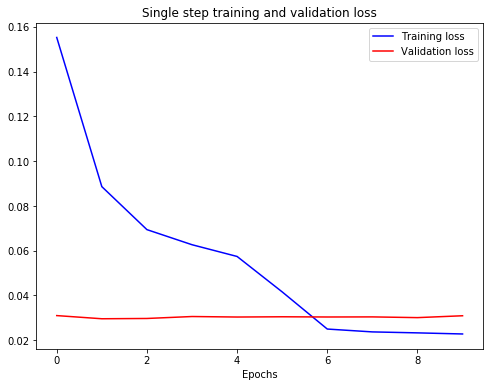

In [107]:
batch_size = 256
buffer_size = 10000

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

validate = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
validate = validate.batch(batch_size).repeat()

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mae')

model_history = model.fit(train, epochs=epochs, steps_per_epoch=steps_per_epoch,
                          validation_data=validate, validation_steps=validation_steps)

plot_train_history(model_history, 'Single step training and validation loss')

Now see how it performs on some validation data:

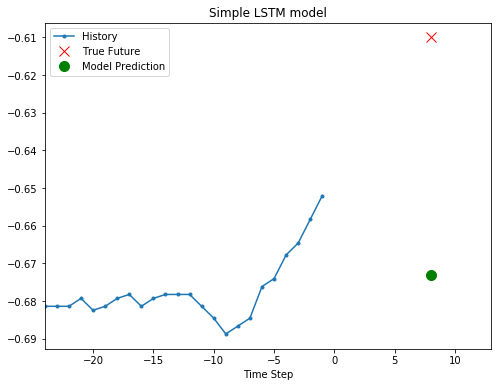

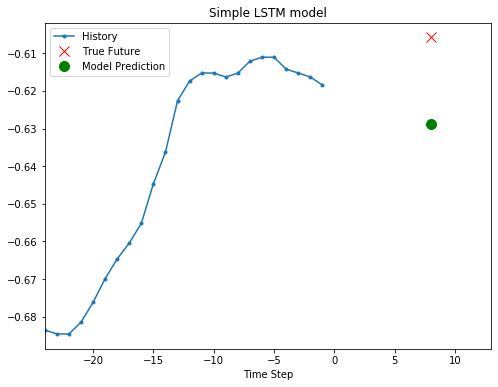

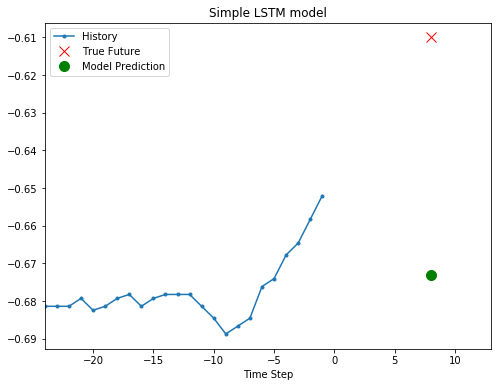

In [108]:
for x, y in validate.take(3):
  show_single_plot([x[0].numpy(), y[0].numpy(),
                   model.predict(x)[0]], future, 'Simple LSTM model')

Then see how it performs globally on the flood period:

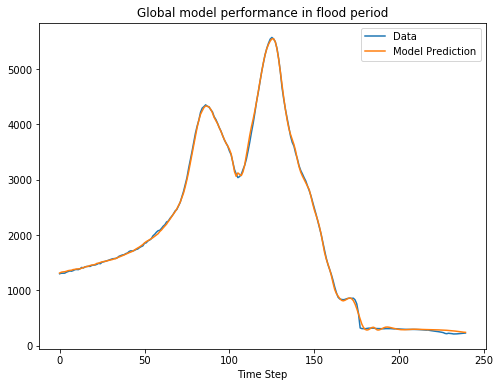

In [109]:
flood_start = 12 * 24 * perHour # 12 days after start period
flood_end = 17 * 24 * perHour # 17 days after start period
ground_truth = []
prediction = []
for i in range(flood_start, flood_end):
    ground_truth.append(data.values[i])
    x = []
    x.append((data.values[i-history-future:i-future]-mean)/std)
    x = np.array(x)
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    prediction.append(model.predict(x)[0]*std+mean)
    
show_prediction(ground_truth, prediction, 'Global model performance in flood period')

We will then work with the multi-step setup, ie given a past history, the model needs to learn to predict a range of future values. Data setup and model training is pretty similar except since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers.

Sample window [[-0.32027621]
 [-0.33182403]
 [-0.35491968]
 [-0.37381612]
 [-0.37171652]
 [-0.34967067]
 [-0.3192264 ]
 [-0.3192264 ]
 [-0.34232205]
 [-0.35177027]
 [-0.37066671]
 [-0.37696553]
 [-0.38116474]
 [-0.39376236]
 [-0.37696553]
 [-0.35491968]
 [-0.33287383]
 [-0.32342561]
 [-0.32762482]
 [-0.32867462]
 [-0.33182403]
 [-0.33707304]
 [-0.33182403]
 [-0.32657502]]
Target level values [-0.32657502 -0.3181766  -0.3171268  -0.31187779 -0.3181766  -0.32342561
 -0.32972443 -0.35177027]


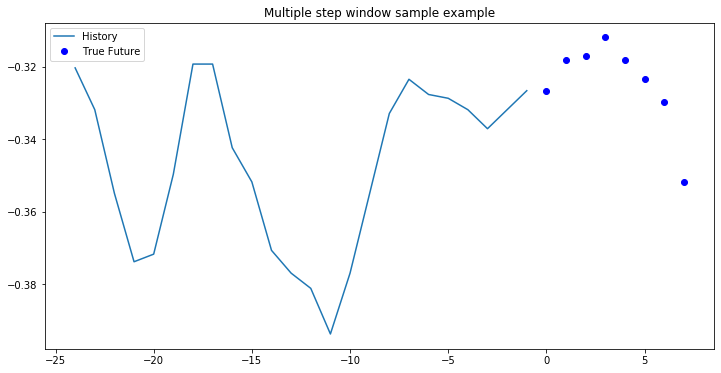

Train for 1000 steps, validate for 500 steps
Epoch 1/10
1000/1000 [==============================] - 52s 52ms/step - loss: 0.1089 - val_loss: 0.0274
Epoch 2/10
1000/1000 [==============================] - 48s 48ms/step - loss: 0.0425 - val_loss: 0.0337
Epoch 3/10
1000/1000 [==============================] - 48s 48ms/step - loss: 0.0324 - val_loss: 0.0303
Epoch 4/10
1000/1000 [==============================] - 48s 48ms/step - loss: 0.0286 - val_loss: 0.0229
Epoch 5/10
1000/1000 [==============================] - 48s 48ms/step - loss: 0.0262 - val_loss: 0.0225
Epoch 6/10
1000/1000 [==============================] - 48s 48ms/step - loss: 0.0245 - val_loss: 0.0202
Epoch 7/10
1000/1000 [==============================] - 48s 48ms/step - loss: 0.0232 - val_loss: 0.0209
Epoch 8/10
1000/1000 [==============================] - 48s 48ms/step - loss: 0.0222 - val_loss: 0.0277
Epoch 9/10
1000/1000 [==============================] - 48s 48ms/step - loss: 0.0214 - val_loss: 0.0187
Epoch 10/10
1000/10

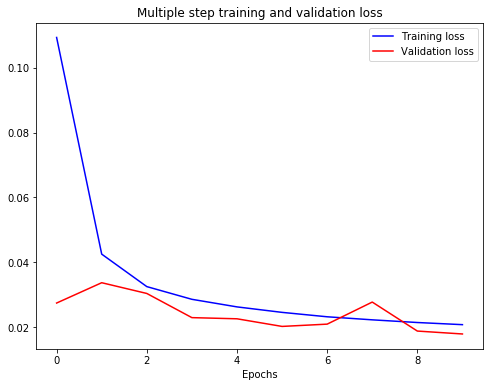

In [92]:
x_train, y_train = data_windows(ndata, 0, train_split, history, future, single_step=False)
x_validate, y_validate = data_windows(ndata, train_split, None, history, future, single_step=False)

print ('Sample window {}'.format(x_train[0]))
print ('Target level values {}'.format(y_train[0]))
    
show_multiple_plot(x_train[0], y_train[0], np.empty([0]), 'Multiple step window sample example')

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

validate = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
validate = validate.batch(batch_size).repeat()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]))
model.add(tf.keras.layers.LSTM(16, activation='relu'))
model.add(tf.keras.layers.Dense(future))

model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

model_history = model.fit(train, epochs=epochs, steps_per_epoch=steps_per_epoch,
                          validation_data=validate, validation_steps=validation_steps)

plot_train_history(model_history, 'Multiple step training and validation loss')

Now see how it performs:

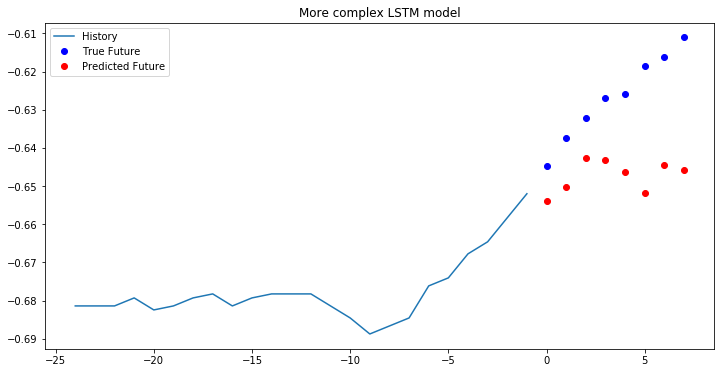

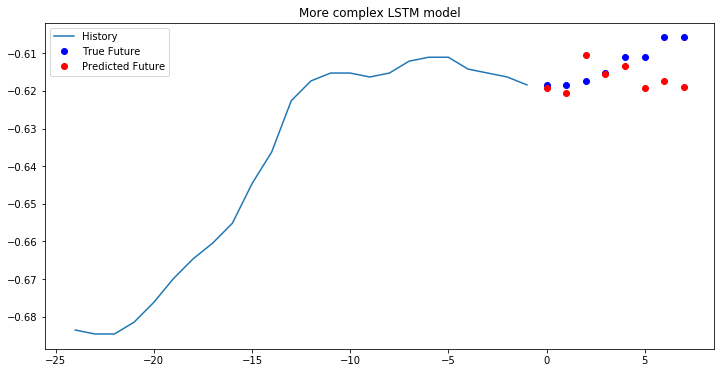

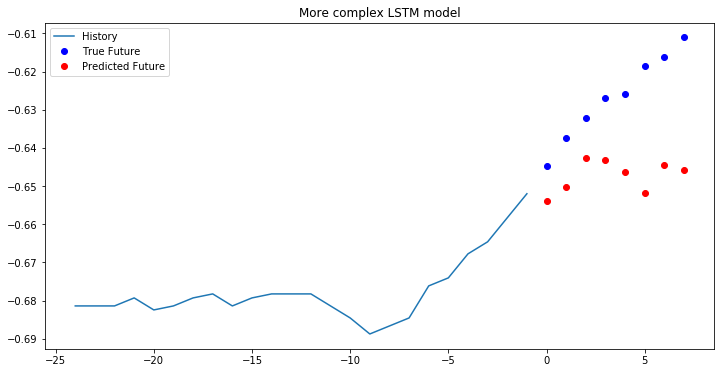

In [95]:
for x, y in validate.take(3):
  show_multiple_plot(x[0], y[0], model.predict(x)[0], 'More complex LSTM model')

Then see how it performs globally on the flood period:

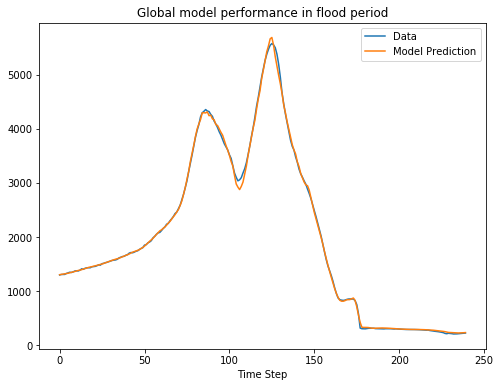

In [100]:
flood_start = 12 * 24 * perHour # 12 days after start period
flood_end = 17 * 24 * perHour # 17 days after start period
ground_truth = []
prediction = []
for i in range(flood_start, flood_end):
    ground_truth.append(data.values[i])
    x = []
    x.append((data.values[i-history:i]-mean)/std)
    x = np.array(x)
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    prediction.append(model.predict(x)[0][0]*std+mean)
    
show_prediction(ground_truth, prediction, 'Global model performance in flood period')